In [226]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
pokemon_counts_df = pd.read_csv("./dataset/showdown/showdown_2players.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_latest = pd.read_csv("./dataset/smogon/2025-06-gen5ou-0.csv")

In [227]:
gen5ou_usage_latest.drop("Rank", axis=1, inplace=True)

Turn Pokemon List sorted by usage, then take Usage%. Use this instead of getting the percentage of each Pokemon to maintain information on Pokemon not recorded by the data.

Suppose a Pokemon is used 27.56% of the time out of all Pokemon, including those not recorded in the database (Around 1.321% out of 600% since there are 6 Pokemon, or 0.22%). By doing this approach, the 27.56% does not get scaled upwards.

In [228]:
pokemon_usage_expected_perc = gen5ou_usage_latest.drop(["Raw", "%", "Real", "%.1"], axis=1)
pokemon_usage_expected_perc
print(pokemon_usage_expected_perc["Usage%"].str.rstrip("%").astype(float).sum())
(600 - pokemon_usage_expected_perc["Usage%"].str.rstrip("%").astype(float).sum()) / 6

598.67911


np.float64(0.22014833333332717)

In [229]:
6/ 598.67911

0.010022063405552934

Pre-processing for Showdown data. Count all the Pokemon in the dataframe, then convert to a dataframe.

In [230]:
showdown_pokemon = pd.concat([pokemon_counts_df["Player " + str(m) + " Pokemon " + str(n)] for m in range(1, 3) for n in range(1, 7)], ignore_index=True)
showdown_pokemon.value_counts()
# Convert to DataFrame
df_counts = showdown_pokemon.value_counts().reset_index()

# Rename columns for clarity
df_counts.columns = ['Pokemon', 'Observed']
df_counts


,Pokemon,Observed
0,Latios,3554
1,Tyranitar,3110
2,Ferrothorn,2817
3,Landorus-Therian,2571
4,Garchomp,2403
...,...,...
251,Cacturne,1
252,Kangaskhan,1
253,Swellow,1
254,Kingler,1


In [ ]:
merged_perc = pd.merge(df_counts, pokemon_usage_expected_perc, left_index=True, right_index=True, how='outer')

merged_perc = merged_perc.fillna(0)

merged_perc["Usage%"] = merged_perc["Usage%"].str.rstrip("%").astype(float)
sum = merged_perc["Usage%"].sum()
merged_perc = merged_perc[merged_perc["Usage%"] >= 0.049889925833333335]
print(sum)
merged_perc["Usage%"].sum()

598.67911


np.float64(596.2374000000001)

Outer Join so that Pokemon that are in the Smogon database (expected) can show up even if the replays gathered do not end up recording a player using said Pokemon.

Since there are 5000 recorded battles, each player using 6 Pokemon would lead to 60000 Pokemon total, (with 1 Pokemon being able to be used a maximum of 2 times in any given match).

A requirement of Chi-Square test is that each observation should be independent of other observations, which is fulfilled by each Pokemon being able to be used by each individual player. The second requirement of Chi-Square test is that each expected count should be at least 5.

With this in mind, any Pokemon with expected uses less than 5 uses should be removed.

A caveat is that since the expected Pokemon values is missing 0.22% of its data, the cut-off value has to be calculated by first, normalizing the usage percent of each pokemon to total 100% instead of 600%, then multiplied to the sum of the expected values after all the Pokemon with less than 5 expected uses is removed.

In [232]:
df_counts["Observed"].sum()

np.int64(60000)

In [233]:
5 * sum / 60000

np.float64(0.049889925833333335)

In [234]:
merged_perc["Usage%"] = merged_perc["Usage%"] / 596.2374000000001
merged_perc["Usage%"].sum()

np.float64(0.9999999999999997)

In [235]:
5 / 60000

8.333333333333333e-05

In [236]:
merged_perc = merged_perc[merged_perc["Usage%"] > 0]
sum = merged_perc["Observed"].sum()
merged_perc["Expected"] = sum * merged_perc["Usage%"]
merged_perc = merged_perc[merged_perc["Expected"] > 5]
merged_perc


,Pokemon_x,Observed,Pokemon_y,Usage%,Expected
0,Latios,3554.0,Latios,0.046233,2774.000759
1,Tyranitar,3110.0,Tyranitar,0.043967,2638.003923
2,Ferrothorn,2817.0,Ferrothorn,0.042344,2540.652431
3,Landorus-Therian,2571.0,Starmie,0.040848,2450.894560
4,Garchomp,2403.0,Garchomp,0.039469,2368.162749
...,...,...,...,...,...
270,0,0.0,Linoone,0.000089,5.326402
271,0,0.0,Whiscash,0.000087,5.213695
272,0,0.0,Meganium,0.000085,5.099982
273,0,0.0,Granbull,0.000085,5.099982


In [237]:
merged_perc["ChiVal"] = (merged_perc["Observed"] - merged_perc["Expected"]) ** 2 / merged_perc["Expected"]
merged_perc

,Pokemon_x,Observed,Pokemon_y,Usage%,Expected,ChiVal
0,Latios,3554.0,Latios,0.046233,2774.000759,219.321792
1,Tyranitar,3110.0,Tyranitar,0.043967,2638.003923,84.450328
2,Ferrothorn,2817.0,Ferrothorn,0.042344,2540.652431,30.058412
3,Landorus-Therian,2571.0,Starmie,0.040848,2450.894560,5.885735
4,Garchomp,2403.0,Garchomp,0.039469,2368.162749,0.512479
...,...,...,...,...,...,...
270,0,0.0,Linoone,0.000089,5.326402,5.326402
271,0,0.0,Whiscash,0.000087,5.213695,5.213695
272,0,0.0,Meganium,0.000085,5.099982,5.099982
273,0,0.0,Granbull,0.000085,5.099982,5.099982


In [238]:
chi2_stat, p_val = sp.chisquare(f_obs=merged_perc["Observed"], f_exp=merged_perc["Expected"])

print("Chi-square statistic:", chi2_stat)
print("p-value:", p_val)

Chi-square statistic: 3340.798475564692
p-value: 0.0


In [248]:
merged_perc["Difference"] = merged_perc["Observed"] - merged_perc["Expected"]
merged_perc

,Pokemon_x,Observed,Pokemon_y,Usage%,Expected,ChiVal,Difference
0,Latios,3554.0,Latios,0.046233,2774.000759,219.321792,779.999241
1,Tyranitar,3110.0,Tyranitar,0.043967,2638.003923,84.450328,471.996077
2,Ferrothorn,2817.0,Ferrothorn,0.042344,2540.652431,30.058412,276.347569
3,Landorus-Therian,2571.0,Starmie,0.040848,2450.894560,5.885735,120.105440
4,Garchomp,2403.0,Garchomp,0.039469,2368.162749,0.512479,34.837251
...,...,...,...,...,...,...,...
270,0,0.0,Linoone,0.000089,5.326402,5.326402,-5.326402
271,0,0.0,Whiscash,0.000087,5.213695,5.213695,-5.213695
272,0,0.0,Meganium,0.000085,5.099982,5.099982,-5.099982
273,0,0.0,Granbull,0.000085,5.099982,5.099982,-5.099982


In [254]:
merged_perc.sort_values(by="ChiVal", ascending=False).head(10)

,Pokemon_x,Observed,Pokemon_y,Usage%,Expected,ChiVal,Difference
0,Latios,3554.0,Latios,0.046233,2774.000759,219.321792,779.999241
1,Tyranitar,3110.0,Tyranitar,0.043967,2638.003923,84.450328,471.996077
5,Politoed,2393.0,Landorus-Therian,0.033136,1988.164781,82.433587,404.835219
8,Jirachi,2091.0,Dragonite,0.028935,1736.116185,72.542681,354.883815
7,Scizor,2116.0,Jirachi,0.029517,1771.022079,67.198352,344.977921
6,Starmie,2125.0,Excadrill,0.030917,1855.000709,39.298970,269.999291
2,Ferrothorn,2817.0,Ferrothorn,0.042344,2540.652431,30.058412,276.347569
42,Chansey,391.0,Darmanitan,0.005000,299.987220,27.612263,91.012780
91,Heracross,46.0,Swampert,0.001628,97.691624,27.351618,-51.691624
41,Toxicroak,395.0,Gastrodon,0.005113,306.786860,25.364704,88.213140


<Axes: >

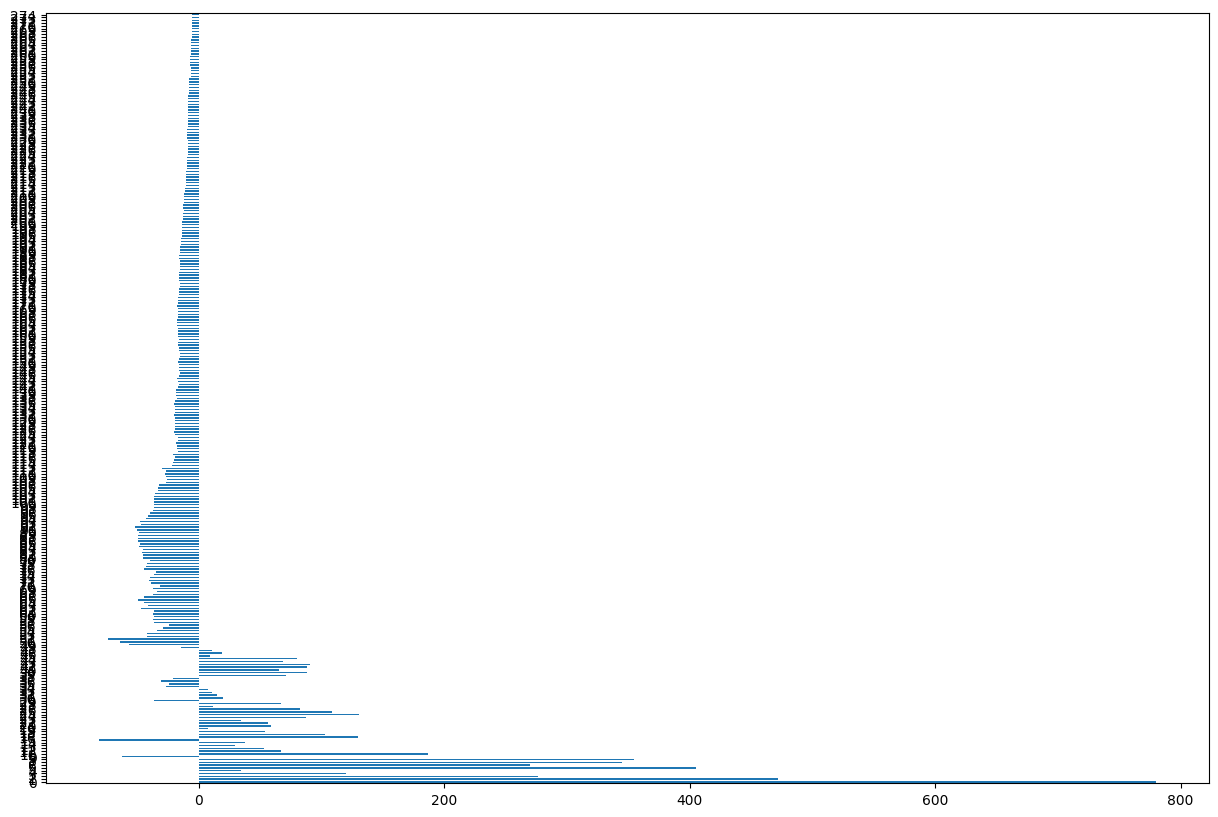

In [250]:
merged_perc["Difference"].plot(kind="barh", figsize=(15, 10))